In [1]:
# accessing project folder in google drive. Once this cell is run, we will be inside project folder.
import os
os.chdir('/content/drive/MyDrive/programs/Datasets/toxic comment classification')

In [5]:
# load all necessary libraries
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from tqdm import tqdm_notebook as tqdm
from wordcloud import WordCloud, STOPWORDS
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn import svm

import warnings
warnings.filterwarnings('ignore')

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# load data 
toxic_data = pd.read_csv('data/train.csv')
print("Shape of data : ", toxic_data.shape)
toxic_data.head()

Shape of data :  (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
# removinbg duplicate data if there are.
toxic_data.drop_duplicates(subset='comment_text', inplace=True)
print('NOw data size is : ',toxic_data.shape)

NOw data size is :  (159571, 8)


'\nfor index, row in toxic_data.iterrows():\n  while index < 5:\n    print("Toxic comment: ", row.toxic_data[\'comment_text\'])\n    for t in toxic_type:\n      if row.toxic_data[data]\n    #print(\'Toxic type: \', row.toxic_data[\'toxic\'])\n'

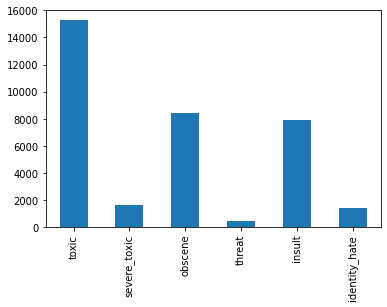

In [8]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
cat_df = toxic_data[categories].sum(axis=0).plot.bar()
"""
for index, row in toxic_data.iterrows():
  while index < 5:
    print("Toxic comment: ", row.toxic_data['comment_text'])
    for t in toxic_type:
      if row.toxic_data[data]
    #print('Toxic type: ', row.toxic_data['toxic'])
"""

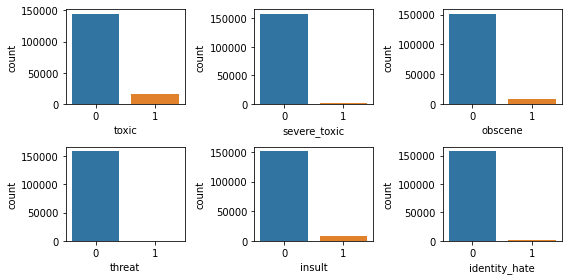

In [9]:
# lets look at the class label distribution of an individual toxic categories
count = 1
plt.figure(figsize=(8,4))
for i, category in enumerate(categories):
  plt.subplot(2,3,count)
  sns.countplot(toxic_data[category])
  count += 1
plt.tight_layout()
plt.show()

Out of aoout 160 thousand observations (online comments),only around 35 thousand comments exhibited toxicity labels (combining all six toxic categores above). This shows that our dataset is highly imbalance. We need to handle such class imbalance which we will do later sections.

In [10]:
stop_words = set(stopwords.words('english'))
# function to preprocess and remove stopwords
def preprocess(text):
  no_stops = []
  sent = text.lower()
  sent = re.sub(r"[^a-zA-Z]"," ",sent)    # removes all characters except alphabets
  sent = re.sub(r'\s+', ' ', sent)       # removes extra white spaces
  #sent = str(text)
  for w in sent.split():
    if not w in stop_words:
      no_stops.append(w)
  return (" ".join(no_stops))

In [11]:
toxic_data['cleaned_comments'] = toxic_data['comment_text'].apply(lambda x: preprocess(str(x)))

In [12]:
X = toxic_data['cleaned_comments'].values  # vector of independent feature (cleaned_comments columns)
Y = toxic_data[categories]       # vectors of target class/categories 
# splitting data into traina and test set 
#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# creating vectorizer
tfidf = TfidfVectorizer(max_features=5000,stop_words='english', max_df=0.7)
tfidf_X = tfidf.fit_transform(X)

# saiving the vectorizer as pickle file
with open("savedmodels/tfidfVectorizer.pkl", "wb") as file:
  pickle.dump(tfidf,file)

In [13]:
# applying undersampling method to downsampe majority class labels. This is done to handle class imbalance
def underSampling(y):
  downsample = RandomUnderSampler(sampling_strategy='majority')
  x_res, y_res = downsample.fit_resample(tfidf_X,y)
  return x_res, y_res

In [14]:
X_toxic, Y_toxic = underSampling(Y['toxic'].values)
X_st, Y_st = underSampling(Y['severe_toxic'].values)
X_insult, Y_insult = underSampling(Y['insult'].values)
X_threat, Y_threat = underSampling(Y['threat'].values)
X_obscene, Y_obscene = underSampling(Y['obscene'].values)
X_identity_hate, Y_identity_hate = underSampling(Y['identity_hate'].values)

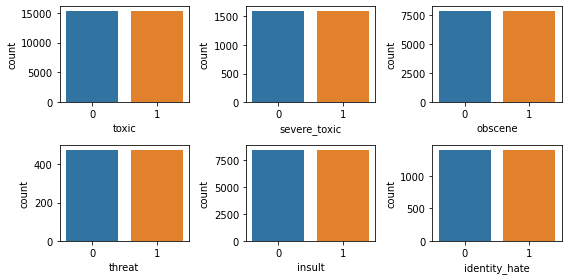

In [15]:
# we just performed random undersampling to handle imabalanced data. Now lets look at the class distribution again
def sampledDist(new_categories):
  count = 1
  plt.figure(figsize=(8,4))
  for i,category in enumerate(new_categories):
    df = pd.DataFrame({categories[i]:list(category)})
    plt.subplot(2,3,count)
    sns.countplot(df[categories[i]])
    count +=1
  plt.tight_layout()
  plt.show()
    
sampledDist([Y_toxic, Y_st, Y_insult, Y_threat, Y_obscene, Y_identity_hate])

We shave now balanced class labels distribution for each toxic categories.

In [16]:
# Splitting data into train:test by 80:20 for each toxic categories
x_train_t, x_val_t, y_train_t, y_val_t = train_test_split(X_toxic, Y_toxic, test_size=0.2, random_state = 42)
x_train_st, x_val_st, y_train_st, y_val_st = train_test_split(X_st, Y_st, test_size=0.2, random_state = 42)
x_train_ins, x_val_ins, y_train_ins, y_val_ins = train_test_split(X_insult, Y_insult, test_size=0.2, random_state = 42)
x_train_th, x_val_th, y_train_th, y_val_th = train_test_split(X_threat, Y_threat, test_size=0.2, random_state = 42)
x_train_obs, x_val_obs, y_train_obs, y_val_obs = train_test_split(X_obscene, Y_obscene, test_size=0.2, random_state = 42)
x_train_ih, x_val_ih, y_train_ih, y_val_ih = train_test_split(X_identity_hate, Y_identity_hate, test_size=0.2, random_state = 42)

In [17]:
## for convenience furing model building and evaluation we dis the following
X_train = [x_train_t, x_train_st, x_train_ins, x_train_th, x_train_obs, x_train_ih]
Y_train = [y_train_t, y_train_st, y_train_ins, y_train_th, y_train_obs, y_train_ih]
X_val = [x_val_t, x_val_st, x_val_ins, x_val_th, x_val_obs, x_val_ih]
Y_val = [y_val_t, y_val_st, y_val_ins, y_val_th, y_val_obs, y_val_ih]

### Model Training and Evaluating  
<small>This is an multilabel classification problem. In such multilabel classification, a same text/independent features can belong to zero or more categores.

In [18]:
from sklearn.metrics import precision_recall_fscore_support
svc_clf = LinearSVC()
linearSVC = LinearSVC()
NB_clf = MultinomialNB()
log_reg = LogisticRegression()

mean_auc_scores = []
mean_acc_scores = []
def execute(model, x_train=X_train, y_train=Y_train, x_test=X_val, option=True):
  accuracies=[]
  auc_scores = []
  if option:
    for i, category in tqdm(enumerate(categories)):
      x_tr = x_train[i].toarray()
      x_val = x_test[i].toarray()
      y_tr = y_train[i]
      model.fit(x_tr,y_tr)
      prediction = model.predict(x_val)

      if len(x_val) == 1:
        if option:
          print('Prediction for {} is {}'.format(category,prediction))
      else:
        print('Test accuracy for {} is {}'.format(category,metrics.accuracy_score(Y_val[i],prediction)))
        accuracies.append(metrics.accuracy_score(Y_val[i], prediction))
        print('AUC score for {} is {}'.format(category, roc_auc_score(Y_val[i],prediction)))
        auc_scores.append(metrics.roc_auc_score(Y_val[i],prediction))
        #print('precision_recall_fscore_support_weighted', precision_recall_fscore_support(Y_val[i], prediction, average='weighted'))
      modelname = 'model_'+category+'.pkl'
      path = 'savedmodels/'+modelname 
      with open(path, 'wb') as file:
        pickle.dump(model,file)
  print('mean accuracy: ', sum(accuracies)/len(accuracies)) if option and len(accuracies)!=0 else None
  print('mean auc score: ', sum(auc_scores)/len(auc_scores)) if option and len(auc_scores)!=0 else None
  mean_auc_scores.append(sum(auc_scores)/len(auc_scores)) if option and len(accuracies)!=0 else None
  mean_acc_scores.append(sum(auc_scores)/len(auc_scores)) if option and len(auc_scores)!=0 else None
  return accuracies, auc_scores

In [19]:
print('Result for MultinomialNB: \n')
accNB, aucNB = execute(NB_clf)

print('\n-------------------------------------------------------------------------\n')
print('Result for Linear Support Vector Machine:\n')
accSVM, aucSVM = execute(svc_clf)

print('\n-------------------------------------------------------------------------\n')
print('Result for Logistic Regression:\n')
accLogReg, aucLogReg = execute(log_reg)

Result for MultinomialNB: 



Test accuracy for toxic is 0.8703824779339654
AUC score for toxic is 0.8706109185122323
Test accuracy for severe_toxic is 0.9388714733542319
AUC score for severe_toxic is 0.9398441880367103
Test accuracy for obscene is 0.8987622976832752
AUC score for obscene is 0.8985813802634176
Test accuracy for threat is 0.890625
AUC score for threat is 0.8866013071895424
Test accuracy for insult is 0.8979289940828402
AUC score for insult is 0.8984646631915294
Test accuracy for identity_hate is 0.905693950177936
AUC score for identity_hate is 0.9069863239413412

mean accuracy:  0.9003773655387081
mean auc score:  0.9001814635224622

-------------------------------------------------------------------------

Result for Linear Support Vector Machine:



Test accuracy for toxic is 0.8772474664923178
AUC score for toxic is 0.8767562286199475
Test accuracy for severe_toxic is 0.9498432601880877
AUC score for severe_toxic is 0.9494004583862051
Test accuracy for obscene is 0.90352269120914
AUC score for obscene is 0.9037306757883795
Test accuracy for threat is 0.9166666666666666
AUC score for threat is 0.9183006535947712
Test accuracy for insult is 0.9266272189349113
AUC score for insult is 0.9261247876197971
Test accuracy for identity_hate is 0.9145907473309609
AUC score for identity_hate is 0.9137102804922875

mean accuracy:  0.914749675137014
mean auc score:  0.9146705140835646

-------------------------------------------------------------------------

Result for Logistic Regression:



Test accuracy for toxic is 0.8813337692056228
AUC score for toxic is 0.8805823873644016
Test accuracy for severe_toxic is 0.9388714733542319
AUC score for severe_toxic is 0.9376801329910192
Test accuracy for obscene is 0.902570612503967
AUC score for obscene is 0.9029800684128462
Test accuracy for threat is 0.8958333333333334
AUC score for threat is 0.8993464052287583
Test accuracy for insult is 0.926923076923077
AUC score for insult is 0.9261764488524026
Test accuracy for identity_hate is 0.9039145907473309
AUC score for identity_hate is 0.9022142793769091

mean accuracy:  0.9082411426779272
mean auc score:  0.9081632870377229


In [20]:

#For MultOutputClasifier strategy
def execute2(model, x_train=X_train, y_train=Y_train, x_test=X_val, verbose=True):
  accuracies=[]
  conf_matrix = []
  for i, category in tqdm(enumerate(categories)):
    x_tr = x_train[i].toarray()
    x_val = x_test[i].toarray()
    y_tr = y_train[i]
    model.fit(x_tr,y_tr)
    y_pred = model.predict(x_val)
    # converting both y_test and y_pred to  array   
    y_test_array = np.array(Y_val[i].tolist())
    y_pred_array = np.array(y_pred.tolist())
    conf_mat = metrics.confusion_matrix(Y_val[i], y_pred)
    print(conf_mat)
  return accuracies

In [21]:
## Confusion Matrix

print('Result for MultinomialNB: \n')
confNB_CM = execute2(NB_clf)

print('\n-------------------------------------------------------------------------\n')
print('Result for Linear Support Vector Machine:\n')
confLogreg = execute2(log_reg)

print('\n-------------------------------------------------------------------------\n')
print('Result for Linear Support Vector Machine:\n')
confSVM_CM = execute2(svc_clf)

Result for MultinomialNB: 



[[2682  439]
 [ 354 2643]]
[[299  30]
 [  9 300]]
[[1372  189]
 [ 130 1460]]
[[74 16]
 [ 5 97]]
[[1496  225]
 [ 120 1539]]
[[249  40]
 [ 13 260]]


-------------------------------------------------------------------------

Result for Linear Support Vector Machine:



[[2864  257]
 [ 469 2528]]
[[321   8]
 [ 31 278]]
[[1479   82]
 [ 225 1365]]
[[86  4]
 [16 86]]
[[1664   57]
 [ 190 1469]]
[[278  11]
 [ 43 230]]


-------------------------------------------------------------------------

Result for Linear Support Vector Machine:



[[2812  309]
 [ 442 2555]]
[[317  12]
 [ 20 289]]
[[1446  115]
 [ 189 1401]]
[[85  5]
 [11 91]]
[[1641   80]
 [ 168 1491]]
[[273  16]
 [ 32 241]]



In [22]:
# for classification report
def execute3(model, x_train=X_train, y_train=Y_train, x_test=X_val, verbose=True):
  accuracies=[]
  for i, category in tqdm(enumerate(categories)):
    x_tr = x_train[i].toarray()
    x_val = x_test[i].toarray()
    y_tr = y_train[i]
    model.fit(x_tr,y_tr)
    y_pred = model.predict(x_val)
    # converting both y_test and y_pred to  array   
    y_test_array = np.array(Y_val[i].tolist())
    y_pred_array = np.array(y_pred.tolist())
    #clf_report = metrics.classification_report(Y_val[i], y_pred)
    clf_report = metrics.classification_report(y_test_array, y_pred_array)
    print('Classification Report for {}'.format(category))
    print(clf_report)
    print('\n')
  return accuracies

In [23]:
print('Result for MultinomialNB: \n')
accNB_cr = execute3(NB_clf)

print('\n-------------------------------------------------------------------------\n')
print('Result for Logistic Regression:\n')
accLogreg = execute3(log_reg)

print('\n-------------------------------------------------------------------------\n')
print('Result for Linear Support Vector Machine:\n')
accSVM_cr = execute3(svc_clf)

Result for MultinomialNB: 



Classification Report for toxic
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3121
           1       0.86      0.88      0.87      2997

    accuracy                           0.87      6118
   macro avg       0.87      0.87      0.87      6118
weighted avg       0.87      0.87      0.87      6118



Classification Report for severe_toxic
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       329
           1       0.91      0.97      0.94       309

    accuracy                           0.94       638
   macro avg       0.94      0.94      0.94       638
weighted avg       0.94      0.94      0.94       638



Classification Report for obscene
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1561
           1       0.89      0.92      0.90      1590

    accuracy                           0.90      3151
   macro avg       

Classification Report for toxic
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      3121
           1       0.91      0.84      0.87      2997

    accuracy                           0.88      6118
   macro avg       0.88      0.88      0.88      6118
weighted avg       0.88      0.88      0.88      6118



Classification Report for severe_toxic
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       329
           1       0.97      0.90      0.93       309

    accuracy                           0.94       638
   macro avg       0.94      0.94      0.94       638
weighted avg       0.94      0.94      0.94       638



Classification Report for obscene
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1561
           1       0.94      0.86      0.90      1590

    accuracy                           0.90      3151
   macro avg       

Classification Report for toxic
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      3121
           1       0.89      0.85      0.87      2997

    accuracy                           0.88      6118
   macro avg       0.88      0.88      0.88      6118
weighted avg       0.88      0.88      0.88      6118



Classification Report for severe_toxic
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       329
           1       0.96      0.94      0.95       309

    accuracy                           0.95       638
   macro avg       0.95      0.95      0.95       638
weighted avg       0.95      0.95      0.95       638



Classification Report for obscene
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1561
           1       0.92      0.88      0.90      1590

    accuracy                           0.90      3151
   macro avg       

In [24]:
## we shall calculate auc_scores and plot roc_auc_curve here
def execute4(model, x_train=X_train, x_test=X_val, y_train=Y_train):
  auc_scores=[]
  count = 1
  plt.figure(figsize=(12,4))
  for i, category in tqdm(enumerate(categories)):
    auc_scores=[]
    x_tr = x_train[i].toarray()
    x_val = x_test[i].toarray()
    y_tr = y_train[i]
    model.fit(x_tr,y_tr)
    y_pred = model.predict(x_val)
    auc_score = roc_auc_score(Y_val[i],y_pred)
    print('AUC scores of '+category+':', auc_score)
    y_pred_prob = model.predict_proba(x_val)[:,1]
    fpr, tpr, thresholds = roc_curve(Y_val[i], y_pred_prob)
    plt.subplot(2,3,count)
    plt.plot([0, 1], [0, 1], 'k--' )
    plt.plot(fpr, tpr, label=category,color = "r")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve '+category,fontsize=12)
    count = count+1
    auc_scores.append(auc_score)
  print('mean auc_score : ', sum(auc_scores)/len(auc_scores))
  print('acu_scores:', auc_scores)
  plt.tight_layout()
  plt.show()

Result for Naive Bayes:



AUC scores of toxic: 0.8706109185122323
AUC scores of severe_toxic: 0.9398441880367103
AUC scores of obscene: 0.8985813802634176
AUC scores of threat: 0.8866013071895424
AUC scores of insult: 0.8984646631915294
AUC scores of identity_hate: 0.9069863239413412

mean auc_score :  0.9069863239413412
acu_scores: [0.9069863239413412]


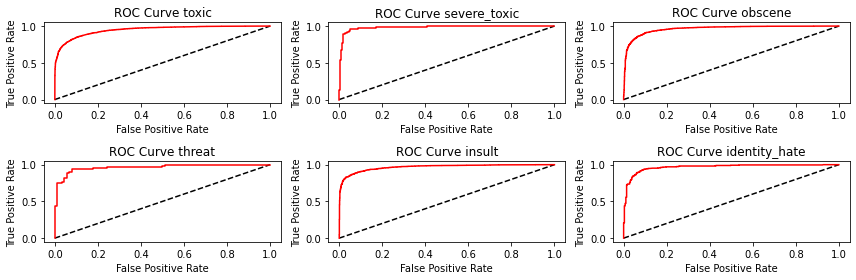


-------------------------------------------------------------------------

Result for Linear SVM:



AUC scores of toxic: 0.8805823873644016
AUC scores of severe_toxic: 0.9376801329910192
AUC scores of obscene: 0.9029800684128462
AUC scores of threat: 0.8993464052287583
AUC scores of insult: 0.9261764488524026
AUC scores of identity_hate: 0.9022142793769091

mean auc_score :  0.9022142793769091
acu_scores: [0.9022142793769091]


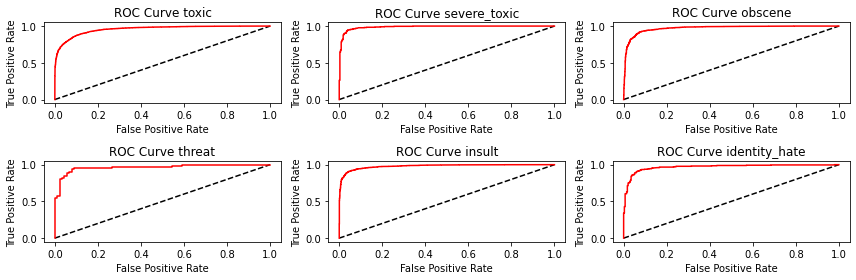

In [25]:
print('Result for Naive Bayes:\n')
roccurveNB = execute4(NB_clf)

print('\n-------------------------------------------------------------------------\n')
print('Result for Linear SVM:\n')
roccurve_logreg = execute4(log_reg)

##### Model comparasion

In [26]:
compare_df = pd.DataFrame()
compare_df['Category'] = categories
compare_df['AUC NB'] = aucNB
compare_df['AUC LogReg'] = aucLogReg
compare_df['AUC SVM'] = aucSVM
compare_df['SVM advantage to NB'] = compare_df['AUC SVM'] - compare_df['AUC NB']
compare_df['SVM advantage to LogReg'] = compare_df['AUC SVM'] - compare_df['AUC LogReg']
compare_df.index = compare_df.Category
compare_df.drop('Category', axis=1, inplace=True)
compare_df.to_csv('model comparison/AUC_comparison.csv')
compare_df

,AUC NB,AUC LogReg,AUC SVM,SVM advantage to NB,SVM advantage to LogReg
Category,,,,,
toxic,0.870611,0.880582,0.876756,0.006145,-0.003826
severe_toxic,0.939844,0.937680,0.949400,0.009556,0.011720
obscene,0.898581,0.902980,0.903731,0.005149,0.000751
threat,0.886601,0.899346,0.918301,0.031699,0.018954
insult,0.898465,0.926176,0.926125,0.027660,-0.000052
identity_hate,0.906986,0.902214,0.913710,0.006724,0.011496


In [27]:
compare_df = pd.DataFrame()
compare_df['Category'] = categories
compare_df['Acc NB'] = accNB
compare_df['Acc LogReg'] = accLogReg
compare_df['Acc SVM'] = accSVM
compare_df['SVM advantage to NB'] = compare_df['Acc SVM'] - compare_df['Acc NB']
compare_df['SVM advantage to LogReg'] = compare_df['Acc SVM'] - compare_df['Acc LogReg']
compare_df.index = compare_df.Category
compare_df.drop('Category', axis=1, inplace=True)
compare_df.to_csv('model comparison/model2_comparison.csv')
compare_df

,Acc NB,Acc LogReg,Acc SVM,SVM advantage to NB,SVM advantage to LogReg
Category,,,,,
toxic,0.870382,0.881334,0.877247,0.006865,-0.004086
severe_toxic,0.938871,0.938871,0.949843,0.010972,0.010972
obscene,0.898762,0.902571,0.903523,0.004760,0.000952
threat,0.890625,0.895833,0.916667,0.026042,0.020833
insult,0.897929,0.926923,0.926627,0.028698,-0.000296
identity_hate,0.905694,0.903915,0.914591,0.008897,0.010676


In [28]:
models = ['Naiv_Bayes', 'Logistic Regression', 'SVM']
auc_df = pd.DataFrame()
auc_df['Models'] = models
auc_df['Mean AUC Score'] = mean_auc_scores
auc_df.to_csv('model comparison/MeanAUCScores.csv')
print('Mean AUC Scores for models')
auc_df

Mean AUC Scores for models


,Models,Mean AUC Score
0,Naiv_Bayes,0.900181
1,Logistic Regression,0.914671
2,SVM,0.908163


In [29]:
models = ['Naiv_Bayes', 'Logistic Regression', 'SVM']
acc_df = pd.DataFrame()
acc_df['Models'] = models
acc_df['Mean Accuracy Score'] = mean_acc_scores
acc_df.to_csv('model comparison/MeanAccuracyScores.csv')
print('Mean Accuracy Scores for models')
acc_df

Mean Accuracy Scores for models


,Models,Mean Accuracy Score
0,Naiv_Bayes,0.900181
1,Logistic Regression,0.914671
2,SVM,0.908163
